In [1]:
!pwd

/mnt/d/books/iitm/agentBased/codes/covasim/models/vanilla


In [2]:
import math
from os import listdir
from os.path import isfile, join
from datetime import datetime
import numpy as np
import geopandas as gpd
import pandas as pd
from pyproj import CRS
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

In [3]:
states = gpd.read_file('/mnt/d/books/iitm/agentBased/data/tn/states_shape/Admin2.shp')
tn = states[states.ST_NM == 'Tamil Nadu']

In [4]:
class TileSystem:
    def __init__(self):
        self.earth_radius = 63_78_137
        self.min_latitude = -85.05112878
        self.max_latitude = 85.05112878
        self.min_longitude = -180
        self.max_longitude = 180

    @staticmethod
    def clip(n, min_value, max_value):
        return min(max(n, min_value), max_value)

    def map_size(self, level_of_detail):
        return 256 << level_of_detail

    def ground_resolution(self, latitude, level_of_detail):
        latitude = self.clip(latitude, self.min_latitude, self.max_latitude)
        return np.cos(latitude * np.pi / 180) * 2 * np.pi * self.earth_radius / self.map_size(level_of_detail)
    
    def map_scale(self, latitude, level_of_detail, screen_dpi):
        return self.ground_resolution(latitude, level_of_detail) * screen_dpi / 0.0254
    
    def lat_long_to_pixel(self, latitude, longitude, level_of_detail):
        latitude = self.clip(latitude, self.min_latitude, self.max_latitude)
        longitude = self.clip(longitude, self.min_longitude, self.max_longitude)
        
        x = (longitude + 180) / 360
        sin_latitude = np.sin(latitude * np.pi / 180)
        y = 0.5 - np.log((1 + sin_latitude) / (1 - sin_latitude)) / (4 * np.pi)
        
        map_size = self.map_size(level_of_detail)
        
        pixel_x = int(self.clip(x*map_size + 0.5, 0, map_size-1))
        pixel_y = int(self.clip(y*map_size + 0.5, 0, map_size-1))
        
        return pixel_x, pixel_y
    
    def pixel_to_lat_long(self, pixel_x, pixel_y, level_of_detail):
        map_size = self.map_size(level_of_detail)
        x = (self.clip(pixel_x, 0, map_size-1) / map_size) - 0.5
        y = 0.5 - (self.clip(pixel_y, 0, map_size-1) / map_size)
        
        latitude = 90 - 360*np.arctan(np.exp(-2 * np.pi * y)) / np.pi
        longitude = 360 * x
        
        return latitude, longitude
    
    def pixel_to_tile(self, pixel_x, pixel_y):
        tile_x = int(pixel_x / 256)
        tile_y = int(pixel_y / 256)
        return tile_x, tile_y

    def tile_to_pixel(self, tile_x, tile_y):
        pixel_x = tile_x * 256
        pixel_y = tile_y * 256
        return pixel_x, pixel_y

    def tile_to_quadkey(self, tile_x, tile_y, level_of_detail):
        quadkey = ""
        for i in range(level_of_detail, 0, -1):
            digit = 0
            mask = 1 << (i-1)
            if ((tile_x & mask) != 0):
                digit += 1
            if ((tile_y & mask) != 0):
                digit += 2
            quadkey += str(digit)
        return quadkey
    
    def quadkey_to_tile(self, quadkey):
        tile_x, tile_y = 0, 0
        level_of_detail = len(quadkey)
        for i in range(level_of_detail, 0, -1):
            mask = 1 << (i-1)
            if (quadkey[level_of_detail - i] == '0'):
                continue
            elif (quadkey[level_of_detail - i] == '1'):
                tile_x |= mask
            elif (quadkey[level_of_detail - i] == '2'):
                tile_y |= mask
            elif (quadkey[level_of_detail - i] == '3'):
                tile_x |= mask
                tile_y |= mask
            else:
                raise ValueError(f"Invalid quadkey: {quadkey}")
        return level_of_detail, tile_x, tile_y

In [5]:
ts = TileSystem()
control_level = 9

In [6]:
data_folder = '/mnt/d/books/iitm/agentBased/data/fb/Mobility_Tamil_Nadu_Coronavirus_Disease_Prevention_Map_Apr_07_2020_Id/2618166339883143_2020-05-03_2020-05-10_csv'

files = sorted([join(data_folder, f) for f in listdir(data_folder) if isfile(join(data_folder, f))])

In [7]:
quadkeys = set()
for f in files:
    df = pd.read_csv(f)
    df = df[df.country == 'IN']
    quadkeys.update(df.start_quadkey)
    quadkeys.update(df.end_quadkey)
quadkeys = [str(qkey) for qkey in quadkeys]

In [8]:
control_qkeys = list(set([qkey[:control_level] for qkey in quadkeys]))

In [9]:
level, tx, ty = ts.quadkey_to_tile(str(control_qkeys[0]))
px, py = ts.tile_to_pixel(tx, ty)
lat, long = ts.pixel_to_lat_long(px, py, level)
ts.ground_resolution(lat, level) * 256

76598.56726511699

In [10]:
def square_shape(qkey, to=None):
    qkey = str(qkey) if to is None else str(qkey)[:to]
    level, tx, ty = ts.quadkey_to_tile(qkey)
    px, py = ts.tile_to_pixel(tx, ty)
    box = [(px, py), (px+256, py), (px+256, py+256), (px, py+256), (px, py)]
    lats, longs = [], []
    for x, y in box:        
        lat, long = ts.pixel_to_lat_long(x, y, level)
        lats.append(lat); longs.append(long)
    return Polygon(zip(longs, lats))

In [11]:
geometry = [square_shape(qkey, control_level) for qkey in control_qkeys]
qdf = pd.DataFrame({'qkeys': control_qkeys})
tiles = gpd.GeoDataFrame(qdf, crs=CRS("WGS84"), geometry=geometry)

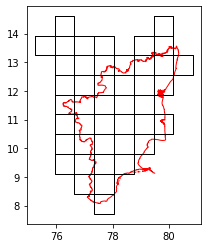

In [12]:
ax = tn.plot(color='white', edgecolor='red')
tiles.plot(ax = ax, color='none', edgecolor='black' )
plt.show()

In [13]:
aoi = gpd.overlay(tiles, tn, how='intersection')

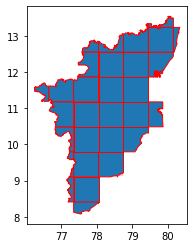

In [14]:
ax = aoi.plot(edgecolor='red')

In [15]:
# tn_quadkeys 

In [16]:
tn_quadkeys = sorted(aoi.qkeys.to_list())
for i in range(len(tn_quadkeys)):
    print(f"{i} {tn_quadkeys[i]}")

0 123303312
1 123303313
2 123303322
3 123303323
4 123303330
5 123303331
6 123303332
7 123303333
8 123312200
9 123312201
10 123312202
11 123312203
12 123312212
13 123312220
14 123312221
15 123312222
16 123321101
17 123321103
18 123321110
19 123321111
20 123321112
21 123321113
22 123321121
23 123321123
24 123321130
25 123321131
26 123321132
27 123321310
28 123330000
29 123330001
30 123330002


In [17]:
# # Run only once 
# quadkey_file = '/mnt/d/books/iitm/agentBased/codes/covasim/models/data/tn_quadkey.csv'
# with open(quadkey_file, 'w') as fp:
#     for q in tn_quadkeys:
#         fp.write(f'{q}\n')

In [18]:
def binary_search(arr, key, to):
    key = key[:to]
    l, r = 0, len(arr)
    while (l < r):
        mid = l + (r-l)//2
        if (arr[mid] > key):
            r = mid
        else:
            l = mid+1
    idx = l-1
    if (idx < 0 or arr[idx] != key):
        return -1
    return idx

In [19]:
aoi['rep_point'] = aoi['geometry'].apply(lambda x: x.representative_point().coords[:])
aoi['rep_point'] = [coords[0] for coords in aoi['rep_point']]

aoi['index'] = aoi['qkeys'].apply(lambda x: binary_search(tn_quadkeys, x, 9))

In [20]:
aoi.head(n=5)

,qkeys,ST_NM,geometry,rep_point,index
0,123303323,Tamil Nadu,"POLYGON ((77.34375 11.17840, 76.70409 11.17840...","(76.9921875, 11.417514394081628)",3
1,123321131,Tamil Nadu,"MULTIPOLYGON (((78.75000 9.79568, 78.75000 9.2...","(78.3984375, 9.505205497128065)",25
2,123312200,Tamil Nadu,"POLYGON ((79.45312 13.23995, 79.43773 13.23995...","(79.44931028586014, 13.29568607727995)",8
3,123330002,Tamil Nadu,"POLYGON ((79.45312 10.48781, 79.45312 10.31567...","(78.98903825983419, 10.142553004812768)",30
4,123330001,Tamil Nadu,"POLYGON ((79.85592 11.17840, 79.85623 11.17614...","(79.64152706762884, 10.834022074125716)",29


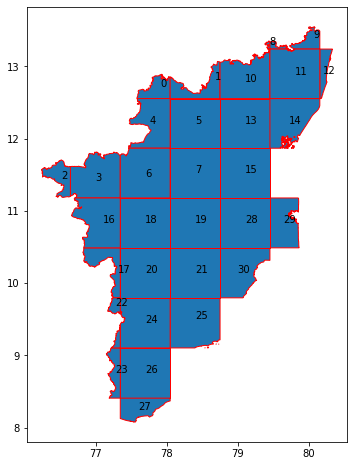

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = aoi.plot(ax=ax, edgecolor='red')
for i, row in aoi.iterrows():
    ax.annotate(row['index'], xy=row['rep_point'], xytext=(0,0), textcoords="offset points", color='black')
plt.show()

In [22]:
## Experiment : 28-12-2021

In [23]:
tn_districts = '/mnt/d/books/iitm/agentBased/codes/covasim/models/data/tn_districts.txt'

In [24]:
data = []
with open(tn_districts, 'r') as fp:
    for line in fp:
        line = line.strip()
        if not line:
            continue
        keys = [x.strip() for x in line.split(',')]
        d = [keys[0], int(keys[-3]), float(keys[-1]), float(keys[-2])]
        data.append(d)

district_df = pd.DataFrame(data, columns=['district', 'population', 'longitude', 'latitude'])
geometry = [Point(xy) for xy in zip(district_df['longitude'], district_df['latitude'])]
district_gdf = gpd.GeoDataFrame(district_df, crs=CRS("WGS84"), geometry=geometry)

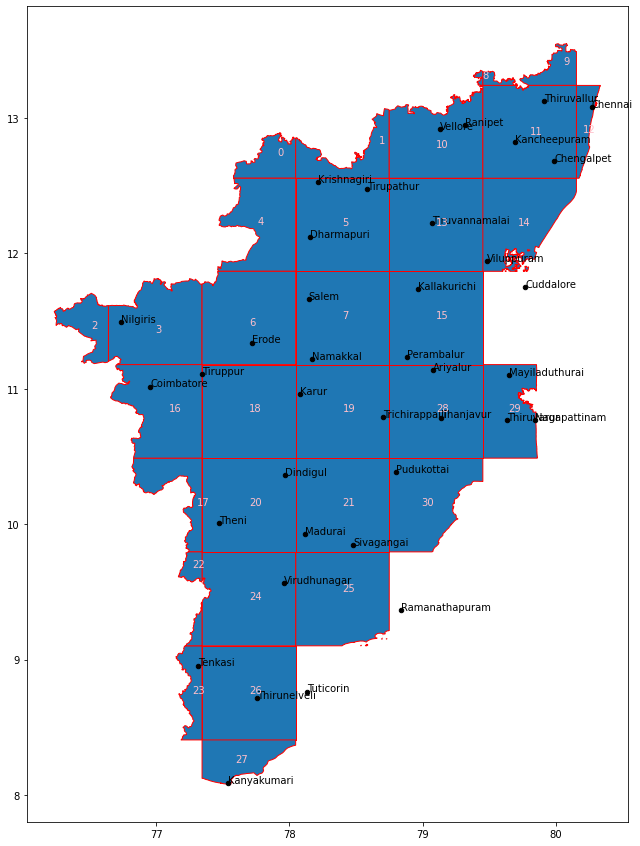

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
aoi.plot(ax=ax, edgecolor='red')
district_gdf.plot(ax=ax, markersize=20, color='black', marker='o', label='district')
for x, y, label in zip(district_gdf.geometry.x, district_gdf.geometry.y, district_gdf.district):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points",)
for i, row in aoi.iterrows():
    ax.annotate(row['index'], xy=row['rep_point'], xytext=(0,0), textcoords="offset points", color='pink')
plt.show()

In [26]:
##

#### Mobility Matrix

In [27]:
def get_mobility(files, tn_quadkeys, to):
    n_tiles = len(tn_quadkeys)
    fb_mobility = np.zeros((n_tiles, n_tiles))
    date = None; days = 0;
    for f in files:
        df = pd.read_csv(f)
        new_date = datetime.strptime(df.date_time[0], '%Y-%m-%d %H:%M').date()
        if new_date != date:
            days += 1
            date = new_date
        df = df[df.country == 'IN']
        base = df.n_baseline.to_numpy()
        winsorized_mean = winsorize(base[~np.isnan(base)], [0.1, 0.2]).mean()
        for idx, row in df.iterrows():
            start, end = str(row['start_quadkey']), str(row['end_quadkey'])
            i, j = binary_search(tn_quadkeys, start, to), binary_search(tn_quadkeys, end, to)
            if (i != -1 and j != -1):
                crisis = row['n_crisis']
                if math.isnan(crisis):
                    crisis = winsorized_mean * (1 + float(row['percent_change'])/100)
                fb_mobility[i, j] += float(crisis)
    fb_mobility /= days
    return fb_mobility

In [28]:
mobility = get_mobility(files, tn_quadkeys, to=control_level)

In [29]:
m, n = mobility.shape
for i in range(m):
    for j in range(n):
        if mobility[i, j] == 0:
            mobility[i, j] = 1
mobility /= mobility.sum(axis=1)[:, np.newaxis]

In [30]:
mobility_file = '/mnt/d/books/iitm/agentBased/codes/covasim/models/data/mobility_matrix.csv'
np.savetxt(mobility_file, mobility, delimiter=",")

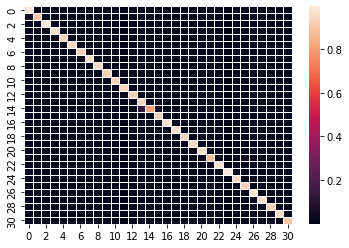

In [31]:
ax = sns.heatmap(mobility, linewidth=0.5)
plt.show()

In [32]:
diag = np.diag(np.diag(mobility))
without_diag = mobility - diag

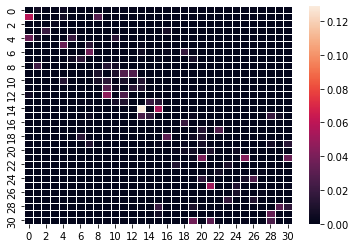

In [33]:
ax = sns.heatmap(without_diag, linewidth=0.5)
plt.show()

### Population Distribution Matrix

In [34]:
pop_folder = '/mnt/d/books/iitm/agentBased/data/fb/Population_Tamil_Nadu_Coronavirus_Disease_Prevention_Map_Apr_07_2020_Id/771489218264088_2020-05-03_2020-05-11_csv'

pop_files = sorted([join(pop_folder, f) for f in listdir(pop_folder) if isfile(join(pop_folder, f))])

In [35]:
def get_population_density(files, tn_quadkeys, to):
    n_tiles = len(tn_quadkeys)
    fb_population = np.zeros(n_tiles)
    date = None; days = 0;
    for f in files:
        df = pd.read_csv(f)
        new_date = datetime.strptime(df.date_time[0], '%Y-%m-%d %H:%M').date()
        if new_date != date:
            days += 1
            date = new_date
        df = df[df.country == 'IN']
        base = df.n_baseline.to_numpy()
        winsorized_mean = winsorize(base[~np.isnan(base)], [0.1, 0.2]).mean()
        for idx, row in df.iterrows():
            qkey = str(row['quadkey'])
            pos = binary_search(tn_quadkeys, qkey, to)
            if pos != -1:
                crisis = row['n_crisis']
                if math.isnan(crisis):
                    crisis = winsorized_mean * (1 + float(row['percent_change'])/100)
                fb_population[pos] += float(crisis)
    fb_population /= days
    return fb_population

In [36]:
population = get_population_density(pop_files, tn_quadkeys, control_level)

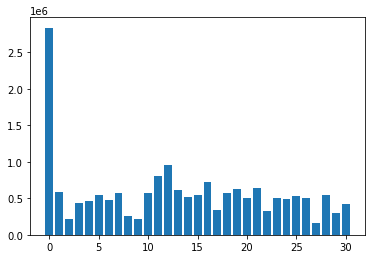

In [37]:
plt.bar(np.arange(len(population)), population)
plt.show()

In [38]:
density = population / np.sum(population)

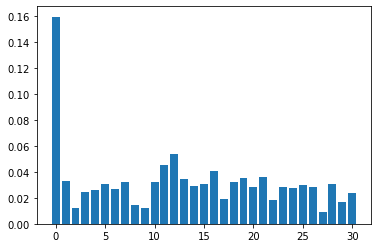

In [39]:
plt.bar(np.arange(len(density)), density)
plt.show()

In [40]:
density_filename = '/mnt/d/books/iitm/agentBased/codes/covasim/models/data/pop_density.csv'
with open(density_filename, 'w') as fp:
    for q, d in zip(tn_quadkeys, density):
        fp.write(f'{q}\t{d}\n')


In [41]:
import geoplot as gplt
import mapclassify as mc

In [42]:
def get_density(row, arr, to):
    qkey = str(row['qkeys'])
    idx = binary_search(arr, qkey, to)
    if idx == -1:
        return 0
    return density[idx]

aoi['pop_density'] = aoi.apply(lambda row: get_density(row, tn_quadkeys, control_level), axis=1)

In [43]:
with_out_highest = aoi.copy(deep=True)
with_out_highest.loc[with_out_highest.qkeys == tn_quadkeys[0], 'pop_density'] = 0

<GeoAxesSubplot:>

/home/rburnwal/miniconda3/envs/covasim/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/rburnwal/miniconda3/envs/covasim/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/rburnwal/miniconda3/envs/covasim/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


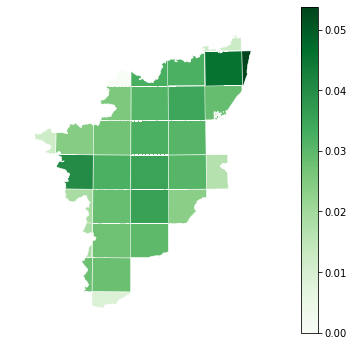

In [44]:
gplt.choropleth(with_out_highest,
                hue='pop_density',
                cmap='Greens', linewidth=0.5,
                edgecolor='white', legend=True,
                projection=gplt.crs.AlbersEqualArea())